# **Clustering and Customer Segmentation**

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### **Step 1: Load the data**


In [8]:
# Load the Data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Convert dates to datetime for processing
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets to create a comprehensive dataset
merged_data = pd.merge(transactions, customers, on="CustomerID", how="inner")

### **Step 2: Feature Engineering**

In [9]:
# Aggregated features for customers
customer_features = merged_data.groupby('CustomerID').agg(
    TotalExpenditure=('TotalValue', 'sum'),  # Sum of TotalValue
    Frequency=('TransactionID', lambda x: len(x)),  # Count the number of transactions
    Recency=('TransactionDate', lambda x: (pd.Timestamp.now() - x.max()).days)  # Days since last transaction
).reset_index()

# One-hot encode 'Region'
region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])
customer_features = pd.merge(customer_features, region_dummies, on="CustomerID", how="left")

# Check the final aggregated DataFrame
print(customer_features.head())


  CustomerID  TotalExpenditure  Frequency  Recency  Region_Asia  \
0      C0001           3354.52          5       86        False   
1      C0002           1862.74          4       55         True   
2      C0003           2725.38          4      156        False   
3      C0004           5354.88          8       35        False   
4      C0005           2034.24          3       84         True   

   Region_Europe  Region_North America  Region_South America  
0          False                 False                  True  
1          False                 False                 False  
2          False                 False                  True  
3          False                 False                  True  
4          False                 False                 False  


### **Step 3: Preprocessing**


In [10]:
# Drop non-numeric and irrelevant columns (e.g., CustomerID)
X = customer_features.drop(columns=["CustomerID"])

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Step 4: Determining Optimal Number of Clusters**


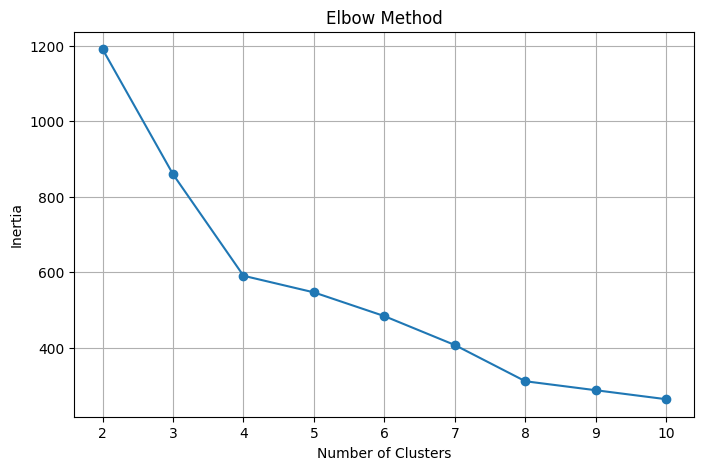

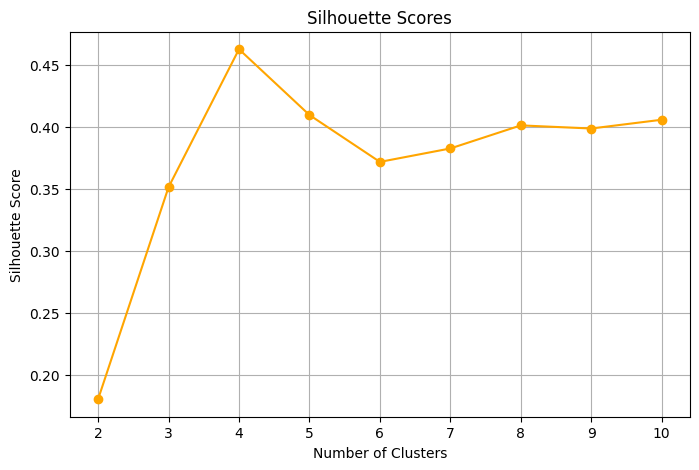

In [11]:
# Test a range of cluster sizes (k) using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
k_values = range(2, 11)  # Test for k between 2 and 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Record inertia for the elbow method
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))  # Silhouette Score

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

### **Step 5: K-Means Clustering**


In [12]:
# Choosing the optimal number of clusters (from the elbow plot or silhouette scores)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

# Adding cluster labels to the original dataframe
customer_features['Cluster'] = kmeans.labels_

### **Step 6: Evaluate Clustering Performance**


In [13]:
# Davies-Bouldin Index (DB Index) and Silhouette Score
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")


Silhouette Score: 0.46
Davies-Bouldin Index: 0.95


### **Step 7: Visualizing Clusters**


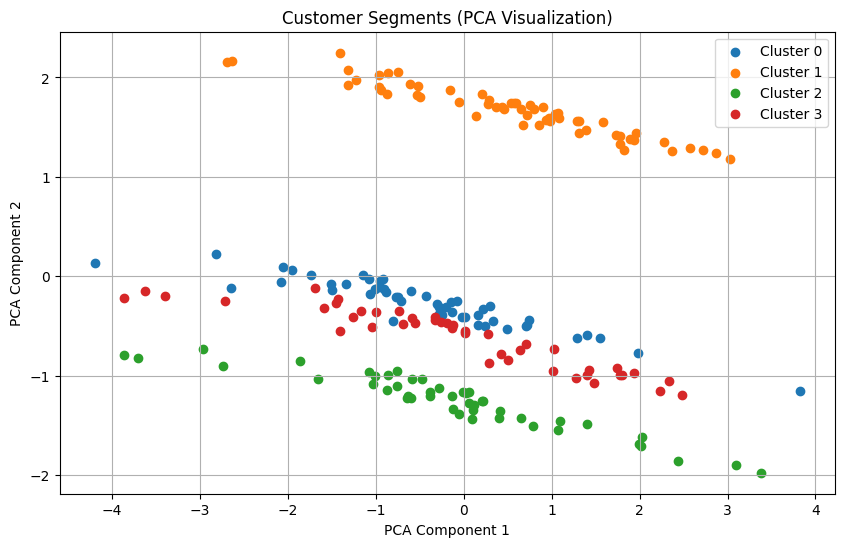

In [14]:
# Reduce dimensions using PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot to visualize clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_data = X_pca[customer_features['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

### **Step 8: Analyze Cluster Profiles**


In [15]:
# Grouping data by clusters and calculating average values for each feature
cluster_profiles = customer_features.drop(columns=['CustomerID']).groupby('Cluster').mean()
print("Cluster Profiles:")
print(cluster_profiles)

# Optional: Saving cluster profiles to a CSV file
cluster_profiles.to_csv("ClusterProfiles.csv", index=True)


Cluster Profiles:
         TotalExpenditure  Frequency     Recency  Region_Asia  Region_Europe  \
Cluster                                                                        
0             3325.092600   4.680000  105.880000          0.0            1.0   
1             3717.840000   5.152542   93.627119          0.0            0.0   
2             3311.160870   5.304348  115.152174          0.0            0.0   
3             3456.249318   4.954545  106.000000          1.0            0.0   

         Region_North America  Region_South America  
Cluster                                              
0                         0.0                   0.0  
1                         0.0                   1.0  
2                         1.0                   0.0  
3                         0.0                   0.0  
